## Notebook for plotting MixIRLS on reference files of ToF-ERDA experiments

In [9]:
import sys
import os
import glob

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt

from utils.preprocess import load_tof, Phi
from utils.plot import make_palette
from image_processing import process

from models.mixture import MixIRLS

Load data, filter noise and feature engineer 

In [10]:
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-1_TiN-ref.lst'
X_raw, y_raw = load_tof(FILE_PATH, unique=True)
X, y = process(X_raw, y_raw, noise_sensitivity=0.9)

exponents = [-1/2, -1]
phi = Phi(X, exponents)

Train model

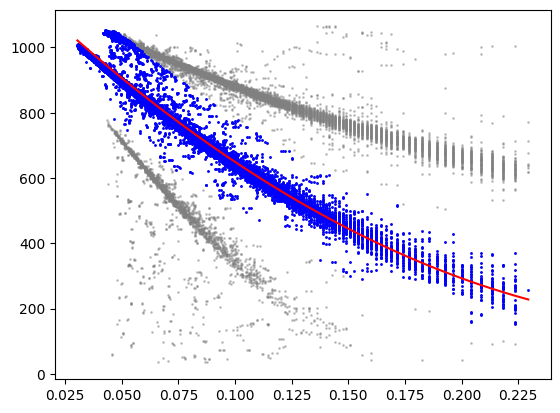

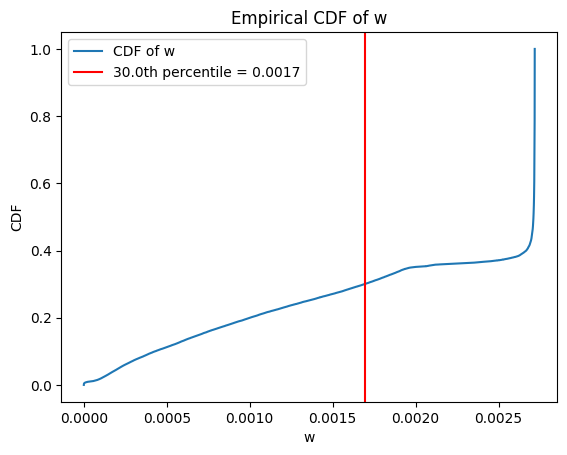

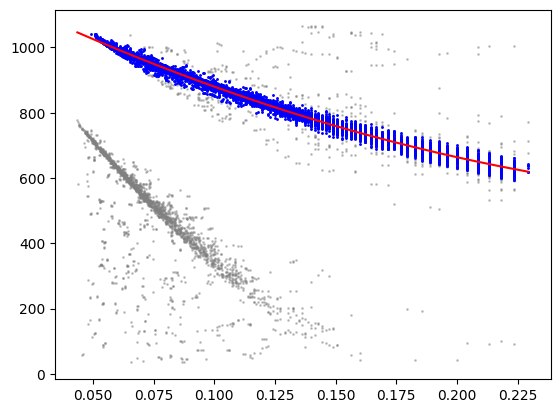

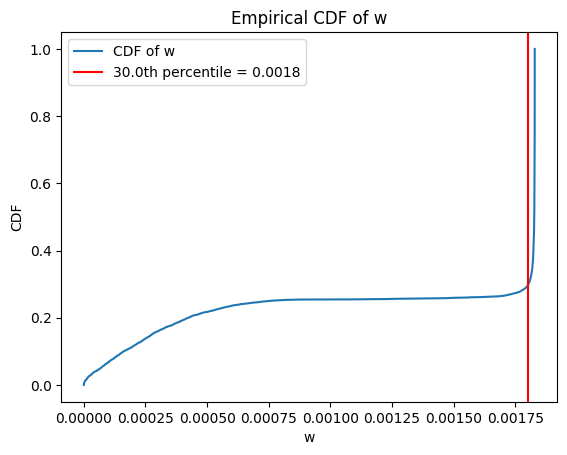

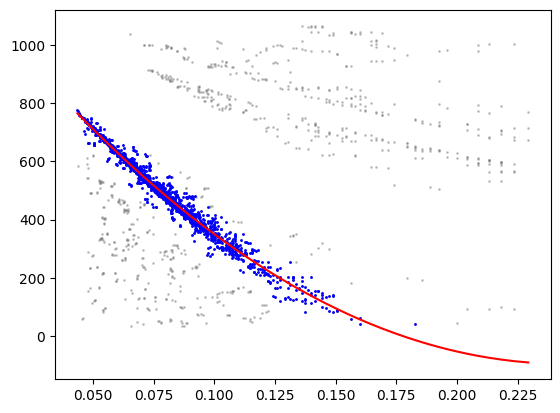

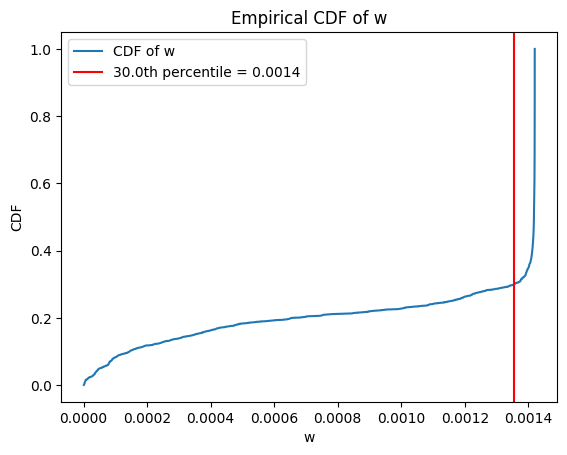

Parameters for 3 components:
 [[  1215.9665115    1195.96767364   1179.42038352]
 [ -6717.23441148  -3660.78726164 -10421.80359817]
 [ 10506.47890783   4997.34593348  21284.0244058 ]]


In [11]:
K = 3
w_th=0.95
plot = True

model = MixIRLS(K=K, w_th=w_th, plot=plot)

sprim, supports, iter = model.train(phi, y)
print(f"Parameters for {K} components:\n", model.beta)

Plot results

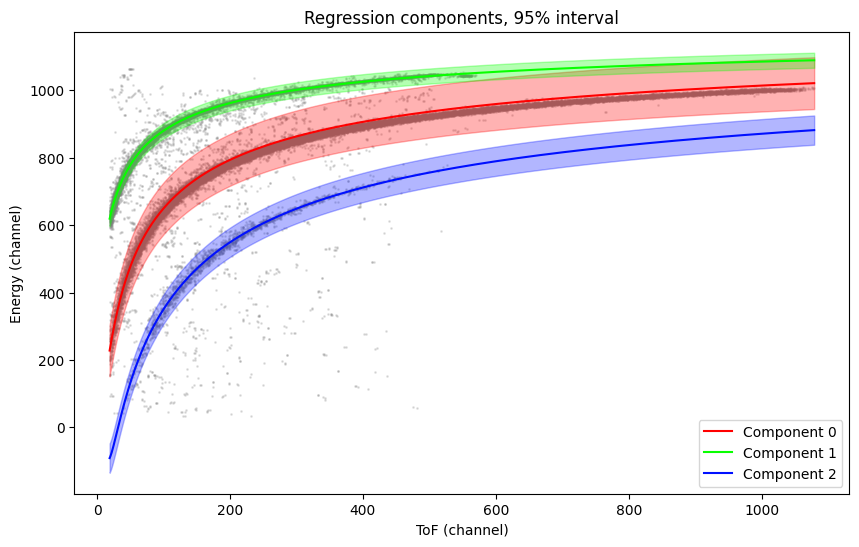

In [12]:
colors = make_palette(K, cmap=plt.cm.hsv)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.2, color='grey', s=1)
plt.xlabel('ToF (channel)')
plt.ylabel('Energy (channel)')
plt.title('Regression components, 95% interval')

# Predict all components at once
y_pred = model.predict(phi)
for k in range(K):
    plt.plot(X, y_pred[:,k], color=colors[k], label=f"Component {k}")
    plt.fill_between(X, y_pred[:,k] - 2*np.sqrt(model.sigma[k]), y_pred[:,k] + 2*np.sqrt(model.sigma[k]), color=colors[k], alpha=0.3)
    
plt.legend()
plt.show()

Points in support for component 0:  28779
  Number of points in component 0:  20145

Points in support for component 1:  8634
  Number of points in component 1:  6044

Points in support for component 2:  2590
  Number of points in component 2:  1813



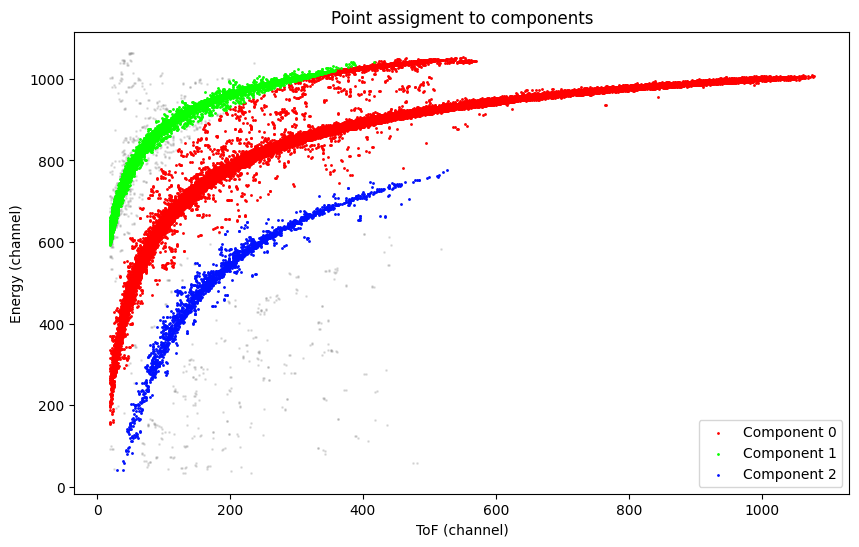

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.2, s=1, color='grey')
plt.xlabel('ToF (channel)')
plt.ylabel('Energy (channel)')
plt.title('Point assigment to components')
for k in range(K):
    
    i, j = model.get_component_indeces(k)
    E, ToF = model.get_component_points(X, y, k)

    print(f"Points in support for component {k}: ", i.sum())
    print(f"  Number of points in component {k}: ", len(X[i][j]), end='\n\n')
    
    plt.scatter(E, ToF, alpha=1, s=1, marker='o',  color=colors[k], label=f"Component {k}")

plt.legend()
plt.show()

In [15]:
def train_and_predict(file_path):
    
    X_raw, y_raw = load_tof(file_path, unique=True)
    X, y = process(X_raw, y_raw, noise_sensitivity=0.8)

    exponents = [-1/2, -1]# + [-1/i for i in range(3,10,2)]
    phi = Phi(X, exponents)
    
    K = 2
    colors = make_palette(K)
    w_th=0.9
    plot = False

    model = MixIRLS(K=K, w_th=w_th, plot=plot)

    sprim, supports, iter = model.train(phi, y)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, alpha=0.2, s=1, color='grey')
    plt.xlabel('ToF (channel)')
    plt.ylabel('Energy (channel)')
    plt.title(f'Point assigment for {file_path}')
    for k in range(K):
        
        i, j = model.get_component_indeces(k)
        E, ToF = model.get_component_points(X, y, k)

        print(f"Points in support for component {k}: ", i.sum())
        print(f"  Number of points in component {k}: ", len(X[i][j]), end='\n\n')
        
        plt.scatter(E, ToF, alpha=1, s=1, marker='o',  color=colors[k], label=f"Component {k}")

    plt.legend()
    plt.show()

file_paths = glob.glob("../data/tof_erda/raw/*.lst")

#for file in file_paths:
    # train_and_predict(file)